# Generate eigenvalues/eigenfunctions of the Laplacian on a unit square

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def LaplaceEigsUnitSquare(grid, num_basis, boundary_condition):
  """ Compute eigenvalues/vectors of the 2D Laplacian on a unit square

  :grid: Tuple (X, Y) of grid of the unit square
  :num_basis: Maximum number of eigenvalues/eigenvectors to compute per dimension
  :boundary_condition: Dirichlet or Neumann boundary condition

  See http://diagramsandcounterexamples.com/unit-square/ for more details
  """
  X, Y = grid
  grid_size = X.shape[0]
  # Maximum number of basis in each dimension is equal to grid size
  N = num_basis if num_basis < grid_size else grid_size
  vals = np.zeros((N, N))
  vecs = np.zeros((N, N, grid_size, grid_size))
  for n in range(N):
    for m in range(N):
      if boundary_condition == 'Dirichlet':
        vals[m,n] = np.pi**2 * ((m+1)**2 + (n+1)**2)
        vecs[m,n] = np.sin(np.pi*(m+1)*X) * np.sin(np.pi*(n+1)*Y)
        vecs[m,n] /= np.linalg.norm(vecs[m,n]) # Normalise
      elif boundary_condition == 'Neumann':
        vals[m,n] = np.pi**2 * (m**2 + n**2)
        vecs[m,n] = np.cos(np.pi*m*X) * np.cos(np.pi*n*Y)
        vecs[m,n] /= np.linalg.norm(vecs[m,n]) # Normalise
  return vals, vecs

In [3]:
# Set up unit-square domain
grid_size = 100
x = y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y, indexing='ij')

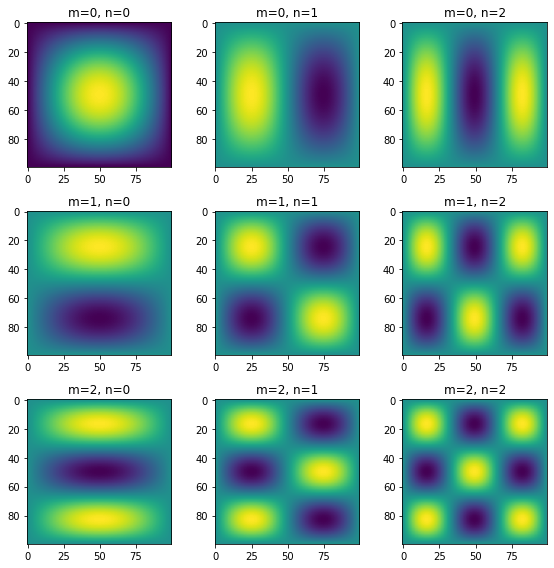

In [126]:
# Plot first 3 Dirichlet eigenfunctions
vals, vecs = LaplaceEigsUnitSquare((X, Y), 8, 'Dirichlet')
fig, axs = plt.subplots(3,3, figsize=(8,8))
for m in range(3):
  for n in range(3):
    axs[m,n].imshow(vecs[m,n])
    axs[m,n].set_title(f"m={m}, n={n}")
plt.tight_layout()

In [127]:
# Plot first 3 Neumann eigenfunctions
# vals, vecs = LaplaceEigsUnitSquare((X, Y), 8, 'Neumann')
# fig, axs = plt.subplots(3,3, figsize=(8,8))
# for m in range(3):
#   for n in range(3):
#     axs[m,n].imshow(vecs[m,n])
#     axs[m,n].set_title(f"m={m}, n={n}")
# plt.tight_layout()

# Generate noisy data from PDE

Generate noisy observations from solution to the Helmholtz equation

$$
(k^2 - \Delta) \,u(x,y) = \mathrm{sin}(2x) \,\mathrm{cos}(2y),
$$
satisfying zero-Neumann condition.

In [67]:
!pip install findiff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


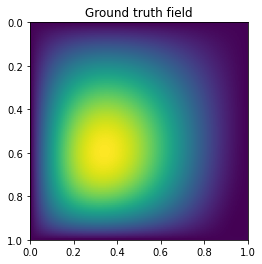

In [128]:
from findiff import FinDiff, Identity, PDE, BoundaryConditions

shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
k = 1
L = k**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
f = np.sin(2*X) * np.cos(2*Y)

# Set boundary conditions (zero-Dirichlet)
bc = BoundaryConditions(shape)
bc[0, :] = 0
bc[-1,:] = 0
bc[:, 0] = 0
bc[:, -1] = 0

# Set boundary conditions (zero-Neumann)
# bc = BoundaryConditions(shape)
# bc[0, :] = FinDiff(0, dx, 1), 0
# bc[-1,:] = FinDiff(0, dx, 1), 0
# bc[:, 0] = FinDiff(1, dy, 1), 0
# bc[:, -1] = FinDiff(1, dy, 1), 0

# Solve PDE
pde = PDE(L, f, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.title('Ground truth field')
plt.show()

In [129]:
np.random.seed(0)

# Sample random locations
num_samples = 70
idxs = np.random.randint(grid_size, size=(2, num_samples)) # Shape (2, N)
X_train = np.array([X[idxs[0], idxs[1]], Y[idxs[0], idxs[1]]]).transpose() # Shape (N, 2)
X_test = np.array([X.flatten(), Y.flatten()]).transpose() # Shape (N*, 2)


# Get noisy observations at these locations
noise_level = 0.1
noise = np.random.randn(num_samples)
y_obs = u[idxs[0], idxs[1]] + noise_level**2 * noise

# Fit GP on this data

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [161]:
# Set up Matern-1 GP
ls = 0.1
nu = 1.0
amp = 1.0
obs_noise = 0.1

kernel = (amp**2) * Matern(length_scale=ls, nu=nu)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=obs_noise**2)

# Fit GP
gpr.fit(X_train, y_obs)
mean, stds = gpr.predict(X_test, return_std=True)

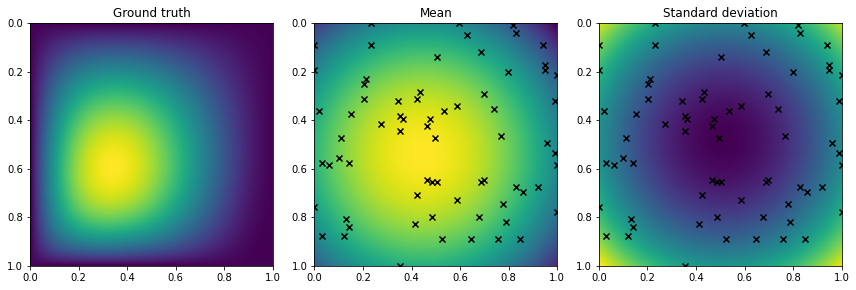

In [162]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(u, extent=[0,1,1,0])
axs[0].set_title('Ground truth')
axs[1].imshow(mean.reshape(shape), extent=[0,1,1,0])
axs[1].scatter(X_train[:,1], X_train[:,0], c='k', marker='x')
axs[1].set_title('Mean')
axs[2].imshow(stds.reshape(shape), extent=[0,1,1,0])
axs[2].scatter(X_train[:,1], X_train[:,0], c='k', marker='x')
axs[2].set_title('Standard deviation')
plt.tight_layout()
plt.show()

In [165]:
mean.max()

0.0028630870603230667

# To do next: Fit boundary GP on this data with correct boundary conditions

In [130]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import findiff
from findiff import FinDiff
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from findiff import FinDiff, PDE, BoundaryConditions, Coef
from findiff.diff import Id
import scipy.ndimage
from scipy.sparse.linalg import eigs as find_eigs
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.image as mpimg


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##Helper Funcs

In [132]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

def plot(observed_pred, train_x, train_y, test_x=torch.linspace(0, 10, 300), true_func = None, mean_adjustment = 0, y_lim = None):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(9, 9))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy() + mean_adjustment, 'b')
        
        if true_func is not None:
            # Plot true function if exists
            ax.plot(test_x.numpy(), true_func, 'green')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy() + mean_adjustment, upper.numpy() + mean_adjustment, alpha=0.5)
        ax.grid(True)
        ax.set_ylim([-4, 4] if y_lim is None else y_lim)
        legend = ['Observed Data', 'Mean', 'True function', 'Confidence']
        ax.legend(legend if true_func is not None else legend[~2])
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function, 
# so that we do not have to repeat the code later on
def train(model, train_x, train_y, likelihood, training_iter=training_iter, verbose = True):
   # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = likelihood(model(train_x))
        
        
        
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        # loss.backward()
        loss.backward(retain_graph = True)
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def make_rectangle(size : np.array, with_pad = True):
    zeros = np.zeros(size + int(with_pad)*np.array([2,2]))
    ones = np.ones(size)
    if with_pad:
        zeros[1:-1,1:-1] = ones
    else:
        zeros = ones
    return zeros
    


##Fixing dataset

In [133]:
print(vals.shape)
print(vecs.shape)

vecs2 = vecs.reshape(64,100,100)
vecs2 = np.moveaxis(vecs2, 0, -1)
vecs2 = vecs2.reshape(100*100,-1)

vals2 = vals.flatten()
print(vecs2.shape)
print(vals2.shape)

(8, 8)
(8, 8, 100, 100)
(10000, 64)
(64,)


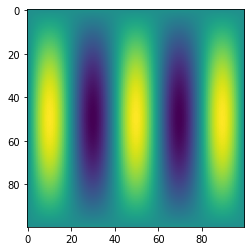

In [134]:
plt.imshow(vecs2[:,4].reshape(100,100))

In [135]:
train_x = torch.as_tensor(X_train).float()
train_y = torch.as_tensor(y_obs).float()
test_x = torch.as_tensor(X_test).float()
print(test_x.shape)
print(train_x.shape)
print(train_y.shape)

torch.Size([10000, 2])
torch.Size([70, 2])
torch.Size([70])


In [136]:


eigvals = torch.as_tensor(vals2).float()
eigvecs = torch.as_tensor(vecs2).float()

##Defining kernel

In [137]:
class BCKernel2D(gpytorch.kernels.Kernel):
    def __init__(self, mask, eigvals, eigvecs, xlim = [0,1], ylim = [0,1], **kwargs):
        
        """
        args:
        dirichlet/neumann are lists of Boundary objects

        It allows for passing a pre-evaluated eigenfunction decomposition of the domain
        """
        super().__init__(**kwargs)

        #Only 2 dimension at the moment
        self.dimension = 2
        self.nu = torch.tensor(2.5, requires_grad = True)
        
        self.eigvals = eigvals
        self.eigvecs = eigvecs
        self.xlim = xlim
        self.ylim = ylim
        
        self.mask = mask
        self.h = (self.xlim[1]-self.xlim[0])/(self.mask.shape[1]+1)
        self.get_eigenvalues()
    
    # the BCkernel is not stationary and has lengthscale
    # is_stationary = True
    has_lengthscale = True

    
    def forward(self, x1, x2, **params):

        
        #Use index in order to calculate \Phi.T \Lambda (diagonal eigenvalues) \Phi (eigenvector)
        #See equation (11) in KnowYourBoundaries.pdf

        spec_eigvals = self._compute_spectral(self.eigvals, **params)
        
        self.big_u_1 = torch.as_tensor(self.eigenfun(x1.numpy())).type(torch.complex128)
        self.big_u_2 = torch.as_tensor(self.eigenfun(x2.numpy())).type(torch.complex128)
        

        big_lambda = spec_eigvals*torch.eye(spec_eigvals.flatten().shape[0])
        covar_matrix = ((self.big_u_1.conj() @ big_lambda.type(torch.complex128) @ self.big_u_2.T)).float()

        return covar_matrix
      
    def get_eigenvalues(self):
          # Solve eigenvalue problem
          mu,V = self.eigvals, self.eigvecs

          # Better approximations of the eigenvalues
          self.hlambda = np.flipud(2*mu / (np.sqrt(1 + mu*self.h**2/3) + 1));

          # Address scaling issues
          V = V * 1/self.h;

              # Expand size to match self.mask
          Vsquare = np.zeros((self.mask.shape[0]*self.mask.shape[1],self.eigvals.shape[0]))
          ind, = np.where(self.mask.flatten())
          for i in range(len(ind)):
              Vsquare[ind[i],:] = V[i,:]

          # Store eigenvectors and self.mask
          # self.V = np.fliplr(Vsquare)
          self.V = Vsquare
          
          self.x1 = np.linspace(self.xlim[0],self.xlim[1],self.mask.shape[1])
          self.x2 = np.linspace(self.ylim[0],self.ylim[1],self.mask.shape[0])
    
    def _compute_spectral(self, eigvals, **params):
        
        '''
        See equation (11) in KnowYourBoundaries.pdf
        '''
        d = self.dimension if torch.is_tensor(self.dimension) else torch.as_tensor(self.dimension)
        l = self.lengthscale
        v = self.nu


        log_gamma_term = torch.lgamma(v + d/2) - torch.lgamma(v)

        # const_term = 2**d * torch.pi ** (d/2) * (2*v)**v / l**(2*v)
        log_const_term = d*torch.log(torch.tensor([2])) + d/2 * torch.log(torch.tensor(torch.pi)) +  v * torch.log(2*v)  -  2*v*torch.log(l)
        
        # We take abs eigvals because the eigenvalues are meant to be positive if we had done the 
        # Negative laplacian instead of the laplacian as the matrix
        foo = (2*v/torch.pow(l,2) + torch.abs(eigvals))

        spectral = torch.exp(log_gamma_term + log_const_term ) * torch.pow((foo), -(2*v+d)/2)
        return spectral
    
    def eigenfun(self,x):
      """
      Evaluate eigenfunctions.
      """
      foo = self.V.reshape((self.mask.shape[0],self.mask.shape[1],self.eigvals.shape[0]))
      U = np.zeros((x.shape[0],self.eigvals.shape[0]))
      for k in range(x.shape[0]):
          i = np.abs(self.x1-x[k,0]).argmin()
          j = np.abs(self.x2-x[k,1]).argmin()
          U[k,:] = foo[j,i,:].flatten()
      return U

In [138]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel = None, mean = None, has_noise = True, is_zero_mean = False, has_mean_adjustment = True):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.base_kernel = None
        self.has_mean_adjustment = has_mean_adjustment if kernel is not None else False
        if kernel is not None:
            self.base_kernel = kernel
            self.scale_kernel = gpytorch.kernels.ScaleKernel(kernel)
        #No kernel function, no mean function (ie baseline)
        if mean is None and kernel is None:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
            self.mean_module = gpytorch.means.ConstantMean() if not is_zero_mean else gpytorch.means.ZeroMean()

        #Kernel supplied, but no mean function
        elif mean is None:
            self.covar_module = self.scale_kernel
            self.mean_module = gpytorch.means.ConstantMean() if not is_zero_mean else gpytorch.means.ZeroMean()
        
        #Kernel and mean function is supplied
        else:
            self.covar_module = self.scale_kernel
            self.mean_module = mean

        if not has_noise:
            # Assume: likelihood noise constraint was defined so that 1e-4 is within range.
            self.likelihood.noise = 1e-4  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
            self.likelihood.noise_covar.raw_noise.requires_grad_(False)  # Mark that we don't want to train the noise.
    
    def forward(self, x):
        covar_x = self.covar_module(x)

        
        if self.has_mean_adjustment:
            mean_x = self.mean_module(x, self.base_kernel.mean_adjustment)
        else:
            mean_x = self.mean_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class KernelMean(gpytorch.means.mean.Mean):
    def __init__(self, domain, batch_shape = torch.Size(), **kwargs):
        super(KernelMean, self).__init__()
        self.batch_shape = batch_shape
        self.domain = domain

    def __call__(self, input, mean_adjustment):
        return self.forward(input, mean_adjustment)

    def forward(self, input, mean_adjustment):
        mean = mean_adjustment
        indices = self.convert_to_index(input)
        return mean[indices]

        
    def convert_to_index(self, input):
        ind_x1 = []
        for xi in input.flatten():
            ix_x1 = torch.where(torch.abs(self.domain - xi) < 1e-6)
            ind_x1.append(ix_x1[0])
            if len(ix_x1[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x1 = torch.concat(ind_x1)
        return ind_x1


In [139]:
# x = np.linspace(0,1, 100)
# x1 = np.repeat(x,100)

# x2 = np.tile(x,100)

# xtest = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis =1)
# test_x = torch.as_tensor(xtest).float()

##Training

In [156]:
train_y

tensor([ 0.0312,  0.0092,  0.0271,  0.0111, -0.0065,  0.0038,  0.0068,  0.0102,
         0.0249,  0.0001,  0.0383, -0.0071,  0.0233,  0.0205, -0.0028,  0.0195,
         0.0244,  0.0102,  0.0152,  0.0214,  0.0150,  0.0132,  0.0258, -0.0025,
         0.0304,  0.0087,  0.0157,  0.0269,  0.0105,  0.0221,  0.0171,  0.0339,
         0.0196,  0.0005,  0.0193, -0.0118,  0.0195, -0.0142, -0.0107,  0.0079,
         0.0335,  0.0064,  0.0434,  0.0191,  0.0191,  0.0132,  0.0317,  0.0065,
         0.0060, -0.0093,  0.0009,  0.0188,  0.0147,  0.0213,  0.0022,  0.0044,
         0.0028,  0.0007, -0.0066,  0.0299,  0.0042,  0.0165, -0.0186,  0.0411,
         0.0019,  0.0155,  0.0176,  0.0235,  0.0408,  0.0145])

In [157]:

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, is_zero_mean = True)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train(model, train_x, train_y, likelihood, verbose = True)
# for i in range(400):
#     optimizer.zero_grad()
#     output = likelihood(model(train_x))
#     loss = -mll(output, train_y)
#     loss.backward()

#     optimizer.step()

Iter 1/100 - Loss: 1.145   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.106   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 1.066   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 1.026   lengthscale: 0.854   noise: 0.554
Iter 5/100 - Loss: 0.985   lengthscale: 0.911   noise: 0.513
Iter 6/100 - Loss: 0.943   lengthscale: 0.971   noise: 0.474
Iter 7/100 - Loss: 0.901   lengthscale: 1.032   noise: 0.437
Iter 8/100 - Loss: 0.859   lengthscale: 1.095   noise: 0.403
Iter 9/100 - Loss: 0.815   lengthscale: 1.158   noise: 0.370
Iter 10/100 - Loss: 0.772   lengthscale: 1.222   noise: 0.340
Iter 11/100 - Loss: 0.727   lengthscale: 1.287   noise: 0.312
Iter 12/100 - Loss: 0.682   lengthscale: 1.353   noise: 0.285
Iter 13/100 - Loss: 0.637   lengthscale: 1.418   noise: 0.261
Iter 14/100 - Loss: 0.591   lengthscale: 1.484   noise: 0.238
Iter 15/100 - Loss: 0.544   lengthscale: 1.549   noise: 0.218
Iter 16/100 - Loss: 0.497   lengthscale: 1.614   noise: 0.198
Iter 17/100 - Los

In [141]:
mask = make_rectangle((100,100), with_pad = False)
bc_k = BCKernel2D(mask, eigvals, eigvecs)
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
model2 = ExactGPModel(train_x, train_y, likelihood2, kernel = bc_k, has_mean_adjustment = False)

print("-----------------------INITIAL PARAMS-------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

print("--------------------------------------------------------------")
model2.train()
likelihood2.train()
train(model2, train_x, train_y, likelihood2, verbose = True)

print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

-----------------------INITIAL PARAMS-------------------------
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: base_kernel.raw_lengthscale                value = 0.0
Parameter name: scale_kernel.raw_outputscale               value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
--------------------------------------------------------------
Iter 1/100 - Loss: 1.096   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.059   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 1.019   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 0.980   lengthscale: 0.853   noise: 0.554
Iter 5/100 - Loss: 0.940   lengthscale: 0.910   noise: 0.513
Iter 6/100 - Loss: 0.899   lengthscale: 0.968   noise: 0.474
Iter 7/100 - Loss: 0.857   lengthscale: 1.028   noise: 0.437
Iter 8/100 - Loss: 0.816   lengthscale: 1.087   noise: 0.403
Iter 9/100 - Loss: 0.773   lengthscale: 1.148   noise: 0.370
Iter 10/100 - Loss: 0.730   lengthscale: 

##Plotting

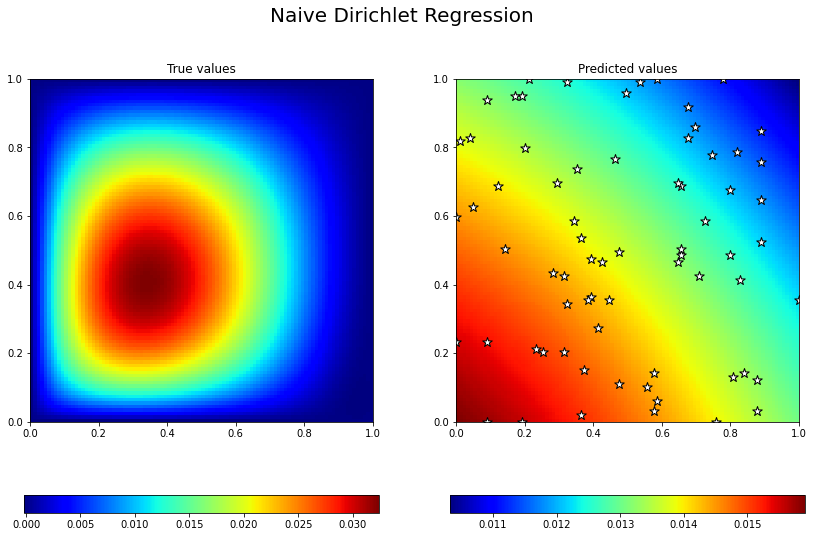

In [159]:
from matplotlib import cm

u_true = u
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

# Test points
n1, n2 = 100, 100
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)])


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    predictions = model(test_x)
    mean = predictions.mean

# mean, stds = gpr.predict(X_test, return_std=True)

extent = (test_x.min(), test_x.max(), 0, 1)
ax[0].set_title('True values')

ax[1].scatter(train_x[:,0], train_x[:,1], color='white', edgecolors = 'black', marker = '*', s = 100)
ax[1].set_title('Predicted values')
m = ax[0].imshow(u_true, extent=extent, cmap=cm.jet)
fig.colorbar(m, orientation = 'horizontal', ax = ax[0], shrink = 1)
# c = ax[1].imshow(mean.detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
c = ax[1].imshow(mean.reshape(100, 100), extent=extent, cmap=cm.jet)

fig.colorbar(c, orientation = 'horizontal', ax = ax[1], shrink = 1)
plt.subplots_adjust(bottom = .2)
fig.suptitle('Naive Dirichlet Regression', fontsize = 20)
plt.savefig('2D_dirichlet_naive.png')



In [143]:
print(mean.detach().numpy())
print(u_true.flatten())

[0.01283278 0.0128141  0.01279491 ... 0.01302226 0.01294895 0.0128754 ]
[0. 0. 0. ... 0. 0. 0.]


In [144]:
mean.detach().numpy().max()

0.017408613

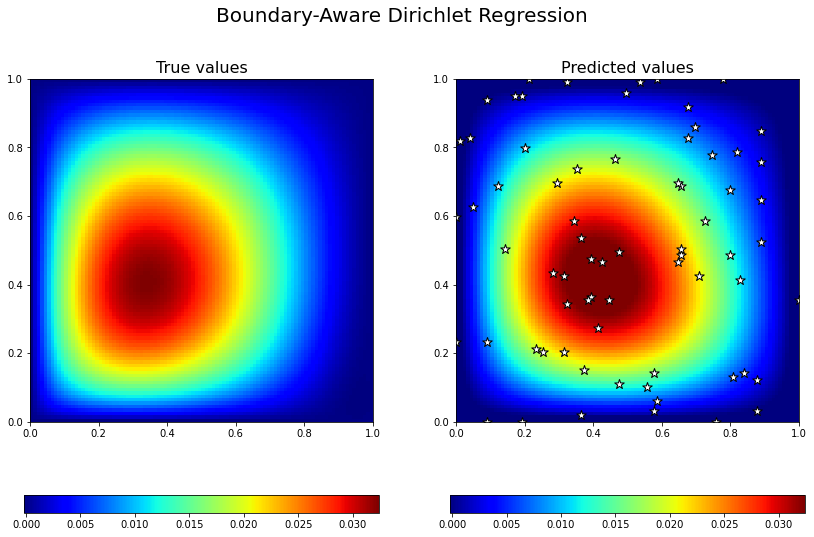

In [148]:
u_true = u
# Set into eval mode
model2.eval()
likelihood2.eval()

# Initialize plots
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

# Test points
n1, n2 = 100, 100
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)])


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    predictions = model2(test_x)
    mean = predictions.mean

extent = (test_x.min(), test_x.max(), 0, 1)
ax[0].set_title('True values', fontsize = 16)

ax[1].scatter(train_x[:,0], train_x[:,1], color='white', edgecolors = 'black', marker = '*', s = 100)
ax[1].set_title('Predicted values', fontsize = 16)
m = ax[0].imshow(u_true, extent=extent, cmap=cm.jet)
fig.colorbar(m, orientation = 'horizontal', ax = ax[0], shrink = 1)
c = ax[1].imshow(mean.detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet, vmin = u_true.min(), vmax = u_true.max())
fig.colorbar(c, orientation = 'horizontal', ax = ax[1], shrink = 1)
plt.subplots_adjust(bottom = .2)
fig.suptitle('Boundary-Aware Dirichlet Regression', fontsize = 20)
plt.savefig('2D_dirichlet_boundary.png')

# mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2)
# metric = mll2(likelihood2(predictions), torch.as_tensor(u_true).flatten().float())
# print(metric)



In [146]:
vecs.shape

(8, 8, 100, 100)

In [147]:
vecs2.shape

(10000, 64)